In [426]:
# print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
#          Andreas Mueller <amueller@ais.uni-bonn.de>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.semi_supervised import label_propagation
import csv
from mpl_toolkits.mplot3d import Axes3D
import sklearn.preprocessing

In [113]:
data_df = pd.read_csv("od_transfer_no_weird_data.csv", delimiter = ',')
data_df.dtypes

/Users/Wenonah/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
## checking 
## csv should not have null value for those following field and have chopped off the outliers
# data_df = data_df.loc[data_df['Walking_time'].notnull()] 
# data_df = data_df.loc[np.logical_and(data_df['Headway'] > 60,  data_df['Headway'] < 4500)]  # headway 1 to 75 min 
# data_df = data_df.loc[data_df['Walking_time'] < 2700]  # walk time with in 45 min    
# data_df.to_csv("od_transfer_no_weird_data.csv", index = False)
# data_df.loc[data_df['Walking_time'].isnull()] # three records have nan walk time
# data_df.loc[np.logical_and(data_df['Headway'] > 60,  data_df['Headway'] < 4500)].shape
# data_df.loc[data_df['Walking_time'] < 2700]

## generate two dummy feature
peak_hour_list = list(range(15,20))+ list(range(5,9))
weekend = ['Sunday','Saturday']
data_df['peak_hour'] = pd.to_datetime(pd.Series(data_df.Transfer_boarding_datetime)).dt.hour.isin(peak_hour_list)
data_df['weekday'] = 1-pd.to_datetime(pd.Series(data_df.Transfer_boarding_datetime)).dt.weekday_name.isin(weekend)
# data_df['peak_hour'].describe()
# data_df['weekday'].describe()

In [221]:
# reading the validation file 
same_route = pd.read_csv("od_transfer_same_route_walkhead_noNaN_2016.csv", delimiter = ',') 
same_route.dtypes

In [1208]:
## getting extra colummns that we could have included in our model 
data_df['cts_bus_missed'] = (data_df['transfer_duration_seconds']-data_df['Walking_time'])/data_df['Headway']
#data_df['hw_td'] = (data_df['transfer_duration_seconds']*data_df['Headway'])**0.5
data_df['hw_wt'] = (data_df['Walking_time']*data_df['Headway'])**0.5
data_df['td_hw_ratio'] = data_df['transfer_duration_seconds']/data_df['Headway']
data_df['td_hw_difference'] = data_df['transfer_duration_seconds']-data_df['Headway']

# data_df.shape
cts_bus_missed = data_df.loc[:, 'cts_bus_missed'].as_matrix()
dis_bus_missed = data_df.loc[:, 'bus_missed'].as_matrix()

In [1209]:
data_df.describe()
# check whether there is any null value 
data_df.loc[np.logical_or(data_df['hw_td'].isnull(), data_df['hw_wt'].isnull())]
data_df.loc[data_df['hw_wt'].isnull()]


,Unnamed: 0,Unnamed: 0.1,transfer_newservice_provider,transfer_boarding_stop_id,transfer_route_taken,day_of_week,transfer_direction,boarding_time,Count,Headway,...,value,peak_hour,weekday,cts_bus_missed,label,final_label,hw_td,hw_wt,td_hw_ratio,td_hw_difference


In [568]:
########################### One naive way to label ###################################
# label data based on bus_missed 
n_samples = data_df.shape[0]

# outer real, inner financial
outer, inner = 0, 1  
data_df['label'] = -1
labels = -np.ones(n_samples)

data_df['label'] = -1
data_df.loc[(data_df['bus_missed'] <= 0) & (data_df['bus_missed'] >= 0),'label'] = outer
data_df.loc[(data_df['bus_missed'] <= 15) & (data_df['bus_missed'] >= 8),'label'] = inner 
labels = np.asarray(data_df['label'])

# print(data_df[data_df['label'] == -1].shape[0])
# print(data_df[data_df['label'] == 0].shape[0])
# print(data_df[data_df['label'] == 1].shape[0])

outerInds = np.asarray(data_df[data_df['label'] == outer].index.tolist())
innerInds = np.asarray(data_df[data_df['label'] == inner].index.tolist())

nOuter = outerInds.shape[0]
nInner = innerInds.shape[0]
nLabel = min(nOuter,nInner)

# downsample the larger labeled set to match the smaller one
# outerInds = outerInds.sample(n=nLabel,replace=False)
# innerInds = innerInds.sample(n=nLabel,replace=False)
outerInds = np.random.choice(outerInds,nLabel,replace=False)
innerInds = np.random.choice(innerInds,nLabel,replace=False)

# print('final sizes:')
# print(outerInds.shape[0])
# print(innerInds.shape[0])

data_df['final_label'] = -1
data_df.loc[outerInds,'final_label'] = outer
data_df.loc[innerInds,'final_label'] = inner

labels = np.asarray(data_df['final_label'])

print( (labels == 0).sum()/n_samples  , " of data is labeled as real")
print( (labels == 1).sum()/n_samples , " of data is labeled as financial")
print( (labels == -1).sum()/n_samples , " of data is unlabeled")


0.0112143860033  of data is labeled as real
0.0112143860033  of data is labeled as financial
0.977571227993  of data is unlabeled


In [1133]:
###################### Labeling we chose #################################
# it is slow but it is the one we chose # 
# label data based on bus_missed and give more penalty when headway is higher
n_samples = data_df.shape[0]

# outer real, inner financial
outer, inner = 0, 1  
labels = -np.ones(n_samples)
random_draw = np.random.uniform(size=n_samples)

index = 0 
for index, row in data_df.iterrows():
    bus_missed = data_df.at[index, 'bus_missed']
    headway = data_df.at[index, 'Headway']
    td = data_df.at[index, 'transfer_duration_seconds']
    if ( random_draw[index] < 0.3)*(bus_missed == 0):
        labels[index] = outer 
    #elif ( random_draw[index] < 0.1)*( bus_missed == 1)*(headway < 2400):
        #labels[index] = outer
    elif bus_missed >= 5 and bus_missed < 20:
        labels[index] = inner
    elif  (bus_missed >= 3)*(headway > 1200):
        labels[index] = inner
    elif  (bus_missed >= 2)*(headway > 1800):
        labels[index] = inner
    elif  (bus_missed >= 1)*(headway > 3600)*(td > 1800):
        labels[index] = inner  
    

print( (labels == 0).sum()/n_samples  , " of data is labeled as real")
print( (labels == 1).sum()/n_samples , " of data is labeled as financial")
print( (labels == -1).sum()/n_samples , " of data is unlabeled") 

0.0482340800783  of data is labeled as real
0.0692092645016  of data is labeled as financial
0.88255665542  of data is unlabeled


In [1245]:
feature_list = ['Headway','transfer_duration_seconds', 'Walking_time']
X1_df = data_df.loc[:, feature_list]
X1 = X1_df.as_matrix()

# one option is to normalize the data 
# but in the model, we did not include this since it is harder to work with our same route file
# but it is something we can explore 
'''
weights = [1, 1, 1]

X2 = np.copy(X1)
X2 = sklearn.preprocessing.scale(X2)
for factor in range(X2.shape[1]):
    X2[:,factor] = weights[factor] * X2[:,factor] 

'''

sample_size = X1.shape[0]
training_set = X1
training_labels = labels


In [1211]:
###### Optional ######
# run model a random sample 
'''
sample_size = 1000000
rand = np.random.choice(n_samples, sample_size, replace = False)
training_set = X1[rand]
training_label = labels[rand]
'''

'\nsample_size = 1000000\nrand = np.random.choice(n_samples, sample_size, replace = False)\ntraining_set = X1[rand]\ntraining_label = labels[rand]\n'

In [1313]:
# feed data into the algorithm
label_spread = label_propagation.LabelSpreading(kernel='knn', alpha= 0.2)
label_spread.fit(training_set, training_labels)
output_labels = label_spread.transduction_

/Users/Wenonah/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:267: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


In [1315]:
# report
financial_transfer = ( output_labels == 1 ).sum()/data_df.shape[0]
print( financial_transfer, " of transfers are predicted to be financial transfer")

0.167682942493  of transfers are predicted to be financial transfer


In [1248]:
# Cleaning the test dataset 
#test_df = same_route.loc[same_route['transfer_duration'] > 10 ]
test_df = same_route.loc[np.logical_or(same_route['transfer_duration']> 30,same_route['transfer_duration'] < 15) ]
#test_df = same_route.loc[same_route['transfer_duration']> 50 ]
#test_df = same_route
test_df['transfer_duration_seconds'] = test_df['transfer_duration']*60
test_df['cts_bus_missed'] = (test_df['transfer_duration_seconds']-test_df['Walking_time'])/test_df['Headway']
test_df['hw_wt'] = (test_df['Walking_time']*test_df['Headway'])**0.5
test_df['td_hw_ratio'] = (test_df['transfer_duration_seconds']/test_df['Headway'])
test_df['td_hw_difference'] = test_df['transfer_duration_seconds']-test_df['Headway']

test_df['peak_hour'] = pd.to_datetime(pd.Series(test_df.transfer_boarding_datetime)).dt.hour.isin(peak_hour_list)
test_df = test_df.loc[np.logical_and(test_df['Headway'] > 600,  test_df['Headway'] < 4500)]  # headway 1 to 75 min 
test_df = test_df.loc[test_df['Walking_time'] < 2700]  # walk time with in 45 min   
test_df['weekday'] = 1-pd.to_datetime(pd.Series(test_df.transfer_boarding_datetime)).dt.weekday_name.isin(weekend)

test_df = test_df.loc[:, feature_list]
test = test_df.as_matrix()

test_labels = np.ones(test.shape[0])
test_labels[test[:, 1] < 900] = 0 

test_labels.mean()



/Users/Wenonah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/Wenonah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Wenonah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

0.83287312376097422

In [1249]:
## report performance of model
test_prob = label_spread.predict_proba(test)
test_predicted_labels = (test_prob[:,0] < test_prob[:, 1]).astype(int)

error_case = test[ test_predicted_labels != test_labels]
# print(error_case.shape[0])
error_predicted_labels = test_predicted_labels[ test_predicted_labels != test_labels]
error_test_labels = test_labels[test_predicted_labels != test_labels]
print((error_test_labels==1).sum()/(error_case.shape[0]), ' of the error case are initilally labeled as financial')

1848
0.981060606061  of the error case are initilally labeled as financial


In [1255]:
# check some negative test case and see whether it is model predit wrongly or we labeled wrongly
rand_sample = np.random.choice(error_case.shape[0], 20, replace = False )
np.set_printoptions(suppress=True)
print('raw data in minutes')
print((np.matrix(error_case[rand_sample])/60).astype(float))
print('expected labels: ')
print(np.asarray(error_test_labels[rand_sample]))
print('predicted labels: ')
print(np.asarray(error_predicted_labels[rand_sample]))

# print(np.matrix(test[rand_sample])/60)
#print(np.matrix(test_predicted_labels[rand_sample]))

raw data in minutes
[[ 15.45        31.75         0.11666667]
 [ 60.13333333  40.16666667   4.43333333]
 [ 29.71666667  30.2          0.06666667]
 [ 59.91666667  56.3          0.36666667]
 [ 59.73333333  40.33333333   0.95      ]
 [ 16.08333333  42.81666667   0.2       ]
 [ 18.51666667  30.35         2.46666667]
 [ 58.65        36.11666667   1.11666667]
 [ 15.45        30.81666667   1.41666667]
 [ 29.16666667  36.8          0.6       ]
 [ 17.61666667  36.68333333   0.13333333]
 [ 13.4         52.25        11.18333333]
 [ 29.55        30.36666667   0.08333333]
 [ 18.38333333  31.38333333   0.51666667]
 [ 56.75        44.18333333   0.        ]
 [ 29.41666667  30.65         0.        ]
 [ 15.08333333  31.16666667   1.88333333]
 [ 60.03333333  37.01666667   0.95      ]
 [ 59.63333333  41.93333333   1.51666667]
 [ 23.03333333  12.88333333   0.4       ]]
expected labels: 
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.]
predicted labels: 
[0 0 0 0 0 0 0 0 0 

In [1316]:
# get the scoare of the model based on the test cases 
label_spread.score(test, test_labels)

0.97448786934768239

In [1277]:
###########  Output Results to CSV 
# output_df = data_df 
# output_df['financial']= pd.Series(output_labels, index= output_df.index)
# output_df.to_csv("od_transfer_financial_label", index = False)

In [1340]:
data_df.shape

(2724982, 49)


# Visualization 


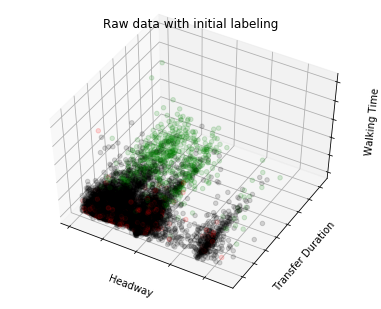

In [1375]:
sample_size = 10000
rand = np.random.choice(n_samples, sample_size, replace = False)
random_sample = X1[rand]

# labels_selected = output_labels[rand] # show result 
labels_selected = labels[rand] # show input 

# random_sample = X1
colors = ['red','green','blue','purple','black']
colors_1 = [colors[int(labels_selected[i])] for i in range(sample_size)]


fig = plt.figure(1, figsize=(5, 4))
plt.clf()
# 'elev' stores the elevation angle in the z plane
ax = Axes3D(fig, elev=50)
plt.cla() #clear axes
ax.scatter(random_sample[:, 0], random_sample[:, 1], random_sample[:, 2], c=colors_1, alpha = 0.15 )

# Plotting just three columns, because we can't plot 4!
ax.w_xaxis.set_ticklabels([]) # Removes markings along the axes
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Headway')
ax.set_ylabel('Transfer Duration ')
ax.set_zlabel('Walking Time')
ax.set_title("Raw data with initial labeling")
#ax.set_title('Labels learned from Label Spreading(KNN)')
#plt.savefig("initial_labels_clear.png", bbox_inches='tight')
plt.savefig("initial_labels.png", bbox_inches='tight')
#plt.savefig("predicated_labels.png", bbox_inches='tight')

plt.show()


1179
(1179, 3)
1179


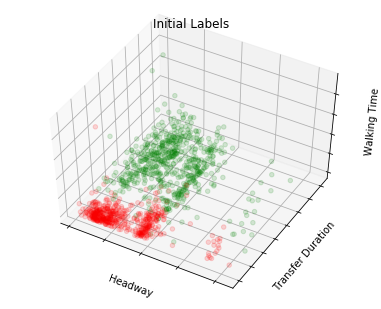

In [1384]:
## only show the labeled points
labels_selected_1 = labels[rand]
labels_selected = labels_selected_1[labels_selected_1 != -1]
print(labels_selected.shape[0])
clear = X1[rand] # the rand from the last visulization
clear = clear[ labels_selected_1 != -1]

print(clear.shape)
# random_sample = X1
colors = ['red','green','blue','purple', 'white']
colors_1 = [colors[int(labels_selected[i])] for i in range(clear.shape[0])]

fig = plt.figure(1, figsize=(5, 4))
plt.clf()
# 'elev' stores the elevation angle in the z plane
ax = Axes3D(fig, elev=50)
plt.cla() #clear axes
ax.scatter(clear[:, 0], clear[:, 1], clear[:, 2], c=colors_1, alpha = 0.15 )

# Plotting just three columns, because we can't plot 4!
ax.w_xaxis.set_ticklabels([]) # Removes markings along the axes
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Headway')
ax.set_ylabel('Transfer Duration ')
ax.set_zlabel('Walking Time')
ax.set_title("Initial Labels")

plt.savefig("initial_labels_clear.png", bbox_inches='tight')


plt.show()


In [1303]:
# plt.savefig("predicated_labels.png", bbox_inches='tight')
plt.savefig("initial_labels_clear.png", bbox_inches='tight')

In [1020]:
##### visulization in every dimensions 
plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)
plt.scatter(subset[labels == outer, 0], subset[labels == outer, 1], color='navy',
            marker='s', lw=0, label="outer labeled", s=10)
plt.scatter(subset[labels == inner, 0], subset[labels == inner, 1], color='c',
            marker='s', lw=0, label='inner labeled', s=10)
plt.scatter(subset[labels == -1, 0], subset[labels == -1, 1], color='darkorange',
            marker='.', label='unlabeled')
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.xlabel('headway')
plt.ylabel('transfer duration')
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]
plt.scatter(subset[outer_numbers, 0], subset[outer_numbers, 1], color='navy',
            marker='s', lw=0, s=10, label="outer learned")
plt.scatter(subset[inner_numbers, 0], subset[inner_numbers, 1], color='c',
            marker='s', lw=0, s=10, label="inner learned")
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Labels learned with Label Spreading (KNN)")
plt.xlabel('headway')
plt.ylabel('transfer duration')
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
# plt.show()

plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)
plt.scatter(subset[labels == outer, 1], subset[labels == outer, 2], color='navy',
            marker='s', lw=0, label="outer labeled", s=10)
plt.scatter(subset[labels == inner, 1], subset[labels == inner, 2], color='c',
            marker='s', lw=0, label='inner labeled', s=10)
plt.scatter(subset[labels == -1, 1], subset[labels == -1, 2], color='darkorange',
            marker='.', label='unlabeled')
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.xlabel('transfer duration')
plt.ylabel('walk time')
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
plt.scatter(subset[outer_numbers, 1], subset[outer_numbers, 2], color='navy',
            marker='s', lw=0, s=10, label="outer learned")
plt.scatter(subset[inner_numbers, 1], subset[inner_numbers, 2], color='c',
            marker='s', lw=0, s=10, label="inner learned")
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Labels learned with Label Spreading (KNN)")
plt.xlabel('transfer duration')
plt.ylabel('walk time')
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
# plt.show()

plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)
plt.scatter(subset[labels == outer, 0], subset[labels == outer, 2], color='navy',
            marker='s', lw=0, label="outer labeled", s=10)
plt.scatter(subset[labels == inner, 0], subset[labels == inner, 2], color='c',
            marker='s', lw=0, label='inner labeled', s=10)
plt.scatter(subset[labels == -1, 1], subset[labels == -1, 2], color='darkorange',
            marker='.', label='unlabeled')
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.xlabel('headway')
plt.ylabel('walk time')
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
plt.scatter(subset[outer_numbers, 0], subset[outer_numbers, 2], color='navy',
            marker='s', lw=0, s=10, label="outer learned")
plt.scatter(subset[inner_numbers, 0], subset[inner_numbers, 2], color='c',
            marker='s', lw=0, s=10, label="inner learned")
plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Labels learned with Label Spreading (KNN)")
plt.xlabel('headway')
plt.ylabel('walk time')
plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)


plt.show()

KeyboardInterrupt: 